# Carregamento dos dados

In [59]:
import pandas as pd

# Definindo o caminho para o arquivo CSV com os dados das análises de aplicativos
file_path = '../Base/apps_reviews_validacao.xlsx - apps_reviews.csv'

# Carregando os dados do arquivo CSV em um DataFrame do pandas
# Usecols: Especifica as colunas a serem carregadas do arquivo
# 'reviewId', 'app_name', 'content', 'sentiment_polarity', 'sentiment' são as colunas selecionadas
# A última coluna nula é ignorada
comentarios = pd.read_csv(file_path, usecols=['reviewId', 'app_name', 'content', 'sentiment_polarity', 'sentiment'])

# Pré-processamento

In [60]:
import sys
import os

# Adicionando um diretório ao caminho de busca de módulos do Python
# os.path.abspath(os.path.join('..', 'lib')): Cria o caminho absoluto para o diretório 'lib' que está um nível acima do diretório atual
# sys.path.append(): Adiciona o diretório especificado ao caminho de busca de módulos, permitindo importar módulos localizados nesse diretório
sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

<p style="color:green">Usar função criada para pré-processamento.</p> 

In [61]:
import pre_processamento as pp

# Chamando a função 'pre_processar_dataframe' do módulo 'pre_processamento'
# A função é usada para pré-processar a coluna 'content' do DataFrame 'comentarios'
# Executa todas operações de limpeza contidos em Base/Base_trabalho_final.ipynb
comentarios = pp.pre_processar_dataframe(comentarios, 'content')

# Extração da features (representação de texto em formato vetorial)

<p style="color:green">A seguir, faremos a instanciação do método que fará a representação do texto usando Doc2Vec.</p> 

In [62]:
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk

# Transformando os comentários em um formato adequado para o modelo Doc2Vec
# TaggedDocument: Estrutura que associa um documento (lista de palavras) a uma etiqueta (tag)
# Cada comentário é tokenizado e associado a um índice único
comentarios_tagged = [TaggedDocument(words=nltk.word_tokenize(text), tags=[str(i)]) 
                      for i, text in enumerate(comentarios['content'])]

# Criando e treinando o modelo Doc2Vec
# vector_size=100: Tamanho dos vetores de saída
# window=5: Tamanho da janela de contexto
# min_count=2: Ignorar palavras que aparecem menos de 2 vezes
# workers=4: Número de threads para treinamento
# epochs=40: Número de épocas para treinamento
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
doc2vec_model.build_vocab(comentarios_tagged) # Construindo o vocabulário do modelo
doc2vec_model.train(comentarios_tagged, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs) # Treinando o modelo

# Gerando vetores Doc2Vec para cada comentário
# infer_vector: Gera um vetor para um novo documento com base no modelo treinado
comentarios_vectors = [doc2vec_model.infer_vector(nltk.word_tokenize(text)) for text in comentarios['content']]

In [63]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convertendo a lista de vetores Doc2Vec em uma matriz NumPy
# X será uma matriz onde cada linha representa um vetor de documento
X = np.array(comentarios_vectors)

# Separando as variáveis alvo (rótulos) para polaridade e sentimento
# y_polarity: Rótulos de polaridade do sentimento (positivo, negativo ou neutro)
# y_sentiment: Rótulos de sentimento (Happiness, Surprise, Sadness, Neutral, Fear, Disgust, Anger)
y_polarity = comentarios['sentiment_polarity'].values
y_sentiment = comentarios['sentiment'].values

<p style="color:green">Codificação de sentiment e polarity</p> 

In [64]:
# Codificando as classes de polaridade de string para números inteiros
# LabelEncoder converte as categorias de texto em números inteiros
le_polarity = LabelEncoder()
y_polarity_encoded = le_polarity.fit_transform(y_polarity)

# Convertendo os rótulos inteiros para uma codificação one-hot
# to_categorical transforma os rótulos inteiros em vetores binários
y_polarity_categorical = to_categorical(y_polarity_encoded)

# Codificando as classes de sentimento de string para números inteiros
le_sentiment = LabelEncoder()
y_sentiment_encoded = le_sentiment.fit_transform(y_sentiment)

# Convertendo os rótulos inteiros para uma codificação one-hot
y_sentiment_categorical = to_categorical(y_sentiment_encoded)

# Treinamento e teste

In [65]:
# Dividindo os dados para a tarefa de classificação de polaridade do sentimento
# train_test_split: Divide o conjunto de dados em conjuntos de treino e teste
# test_size=0.2: 20% dos dados serão usados para teste e 80% para treino
# random_state=42: Define uma semente para garantir a reprodutibilidade
X_train_polarity, X_test_polarity, y_train_polarity, y_test_polarity = train_test_split(X, y_polarity_categorical, test_size=0.2, random_state=42)

# Dividindo os dados para a tarefa de classificação de sentimento
# test_size=0.2: 20% dos dados serão usados para teste e 80% para treino
# random_state=42: Define uma semente para garantir a reprodutibilidade
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X, y_sentiment_categorical, test_size=0.2, random_state=42)


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

def create_model(input_shape, n_classes):
    # Criando um modelo sequencial com Keras
    model = Sequential([
        Input(shape=input_shape), # Camada de entrada com a forma dos dados de entrada
        Dense(128, activation='relu'), # Camada densa com 128 neurônios e ativação ReLU
        Dropout(0.5), # Camada de Dropout para regularização, evita overfitting
        Dense(64, activation='relu'), # Camada densa com 64 neurônios e ativação ReLU
        Dense(n_classes, activation='softmax') # Camada de saída com número de classes, ativação softmax para problemas de classificação multiclasse
    ])
    # Compilando o modelo
    # optimizer='adam': Otimizador Adam para ajustar os pesos do modelo
    # loss='categorical_crossentropy': Função de perda para problemas de classificação multiclasse
    # metrics=['accuracy']: Métrica para avaliar o desempenho do modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Criar o modelo para a tarefa de classificação de sentimento
# input_shape: Forma da entrada do modelo, que corresponde ao número de características dos vetores Doc2Vec
# n_classes: Número de classes na tarefa de classificação de sentimento
model_sentiment = create_model((X_train_sentiment.shape[1],), y_sentiment_categorical.shape[1])

# Criar o modelo para a tarefa de classificação de polaridade
# input_shape: Forma da entrada do modelo, que corresponde ao número de características dos vetores Doc2Vec
# n_classes: Número de classes na tarefa de classificação de polaridade
model_polarity = create_model((X_train_polarity.shape[1],), y_polarity_categorical.shape[1])

In [67]:
# Treinando o modelo para a tarefa de classificação de sentimento
# epochs=10: Número de épocas para treinar o modelo (10 passes completos pelos dados de treinamento)
# batch_size=32: Número de amostras por atualização do gradiente
# validation_data=(X_test_sentiment, y_test_sentiment): Dados de validação usados para monitorar o desempenho do modelo durante o treinamento
model_sentiment.fit(X_train_sentiment, y_train_sentiment, epochs=10, batch_size=32, validation_data=(X_test_sentiment, y_test_sentiment))

# Avaliando o modelo treinado usando os dados de teste
# O método evaluate retorna a perda e a precisão do modelo nos dados de teste
loss, accuracy = model_sentiment.evaluate(X_test_sentiment, y_test_sentiment)
# Imprimindo a precisão do modelo formatada como porcentagem
print(f'Acurácia do modelo para sentiment: {accuracy*100:.2f}%')

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3185 - loss: 1.6787 - val_accuracy: 0.5124 - val_loss: 1.3089
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4971 - loss: 1.2822 - val_accuracy: 0.5423 - val_loss: 1.1565
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5411 - loss: 1.2004 - val_accuracy: 0.5837 - val_loss: 1.1098
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5641 - loss: 1.1143 - val_accuracy: 0.5721 - val_loss: 1.0871
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5627 - loss: 1.0605 - val_accuracy: 0.5788 - val_loss: 1.0782
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5894 - loss: 1.0569 - val_accuracy: 0.5854 - val_loss: 1.0710
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5906 - loss: 1.0273 - val_accuracy: 0.5721 - val_loss: 1.0707
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5892 - loss: 1.0152 - val_accuracy: 0.5705 - val_loss:

In [68]:
from sklearn.metrics import classification_report
import numpy as np

# Gerar previsões para o conjunto de teste
# model_sentiment.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_sentiment = model_sentiment.predict(X_test_sentiment)
y_pred_sentiment = np.argmax(y_pred_sentiment, axis=1)  # Convertendo probabilidades em classes

# Convertendo os rótulos codificados de volta para os rótulos originais
# np.argmax é usado para converter as previsões one-hot de volta para índices de classes
# le_sentiment.inverse_transform converte os índices de volta para os rótulos de texto originais
y_test_sentiment_original = le_sentiment.inverse_transform(np.argmax(y_test_sentiment, axis=1))
y_pred_sentiment_original = le_sentiment.inverse_transform(y_pred_sentiment)

# Gerar o relatório de classificação
# classification_report fornece métricas de desempenho como precisão, recall e F1-score
print("Classification Report for Sentiment:")
print(classification_report(y_test_sentiment_original, y_pred_sentiment_original))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report for Sentiment:
              precision    recall  f1-score   support

       anger       0.54      0.61      0.57       153
     disgust       0.55      0.45      0.49       188
        fear       0.00      0.00      0.00         5
   happiness       0.67      0.61      0.64        64
     neutral       0.00      0.00      0.00        19
     sadness       0.58      0.73      0.64       172
    surprise       0.00      0.00      0.00         2

    accuracy                           0.57       603
   macro avg       0.33      0.34      0.34       603
weighted avg       0.54      0.57      0.55       603



c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


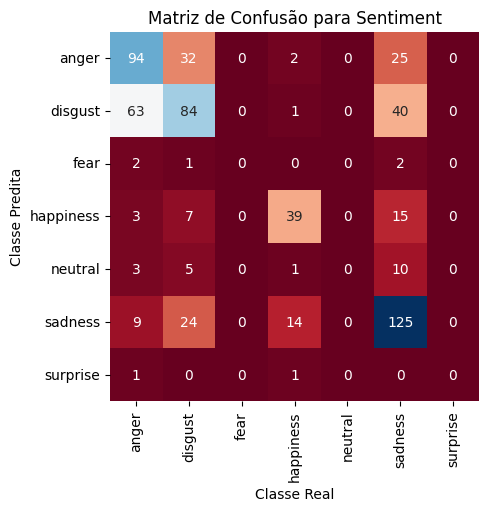

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Gerar previsões para o conjunto de teste
# model_sentiment.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_sentiment = model_sentiment.predict(X_test_sentiment)
y_pred_sentiment = np.argmax(y_pred_sentiment, axis=1)  # Convertendo probabilidades em classes

# Obtendo os rótulos únicos para o sentimento, que serão usados nos eixos da matriz de confusão
# le_sentiment.classes_ fornece os rótulos originais das classes
sentiment_labels = le_sentiment.classes_

# Calculando a matriz de confusão
# confusion_matrix compara as previsões com os rótulos reais
# np.argmax é usado para converter as previsões one-hot de volta para índices de classes
# labels=range(len(sentiment_labels)) garante que todos os rótulos possíveis sejam incluídos na matriz
cm_sentiment = confusion_matrix(np.argmax(y_test_sentiment, axis=1), y_pred_sentiment, labels=range(len(sentiment_labels)))

# Criando um gráfico da matriz de confusão usando seaborn
# sns.heatmap cria um mapa de calor da matriz de confusão
sns.heatmap(cm_sentiment, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False, 
            xticklabels=sentiment_labels,
            yticklabels=sentiment_labels)

plt.xlabel("Classe Real")    # Rótulo do eixo x
plt.ylabel("Classe Predita") # Rótulo do eixo y
plt.title("Matriz de Confusão para Sentiment") # Título do gráfico
plt.show() # Exibindo o gráfico


In [70]:
# Treinar o modelo para a tarefa de classificação de polaridade
# model_polarity.fit treina o modelo com os dados de treinamento para 'sentiment_polarity'
# epochs=10: Número de épocas para treinar o modelo (10 passes completos pelos dados de treinamento)
# batch_size=32: Número de amostras por atualização do gradiente
# validation_data=(X_test_polarity, y_test_polarity): Dados de validação usados para monitorar o desempenho do modelo durante o treinamento
model_polarity.fit(X_train_polarity, y_train_polarity, epochs=10, batch_size=32, validation_data=(X_test_polarity, y_test_polarity))

# Avaliar o modelo treinado usando os dados de teste
# O método evaluate retorna a perda e a precisão do modelo nos dados de teste
loss, accuracy = model_polarity.evaluate(X_test_polarity, y_test_polarity)
# Imprimindo a precisão do modelo formatada como porcentagem
print(f'Acurácia do modelo para sentiment_polarity: {accuracy*100:.2f}%')

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5818 - loss: 0.8357 - val_accuracy: 0.7861 - val_loss: 0.5906
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7427 - loss: 0.6074 - val_accuracy: 0.7977 - val_loss: 0.5324
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7789 - loss: 0.5588 - val_accuracy: 0.7977 - val_loss: 0.5126
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7605 - loss: 0.5611 - val_accuracy: 0.7960 - val_loss: 0.5101
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.5043 - val_accuracy: 0.7977 - val_loss: 0.5100
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7897 - loss: 0.4984 - val_accuracy: 0.7960 - val_loss: 0.5098
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8204 - loss: 0.4502 - val_accuracy: 0.8043 - val_loss: 0.5093
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8143 - loss: 0.4645 - val_accuracy: 0.8027 - val_loss:

In [71]:
from sklearn.metrics import classification_report
import numpy as np

# Gerar previsões para o conjunto de teste
# model_polarity.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_polarity = model_polarity.predict(X_test_polarity)
y_pred_polarity = np.argmax(y_pred_polarity, axis=1)  # Convertendo probabilidades em classes

# Convertendo rótulos codificados de volta para os rótulos originais
# np.argmax é usado para converter as previsões one-hot de volta para índices de classes
# le_polarity.inverse_transform converte os índices de volta para os rótulos de texto originais
y_test_polarity_original = le_polarity.inverse_transform(np.argmax(y_test_polarity, axis=1))
y_pred_polarity_original = le_polarity.inverse_transform(y_pred_polarity)

# Gerar o relatório de classificação
print("Classification Report for Sentiment Polarity:")
print(classification_report(y_test_polarity_original, y_pred_polarity_original))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report for Sentiment Polarity:
              precision    recall  f1-score   support

    negative       0.82      0.86      0.84       346
     neutral       0.00      0.00      0.00        19
    positive       0.77      0.78      0.77       238

    accuracy                           0.80       603
   macro avg       0.53      0.55      0.54       603
weighted avg       0.78      0.80      0.79       603



c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


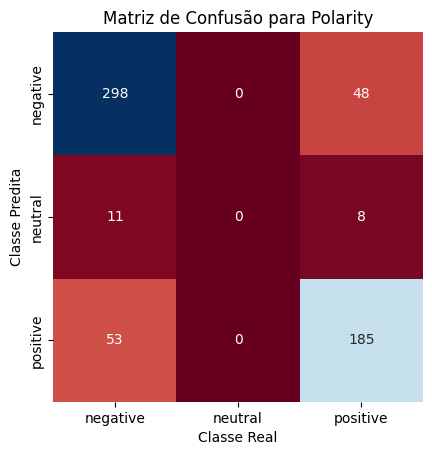

In [72]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Gerar previsões para o conjunto de teste
# model_polarity.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_polarity = model_polarity.predict(X_test_polarity)
y_pred_polarity = np.argmax(y_pred_polarity, axis=1)  # Convertendo probabilidades em classes

# Obtendo os rótulos únicos para polaridade, que serão usados nos eixos da matriz de confusão
# le_polarity.classes_ fornece os rótulos originais das classes
polarity_labels = le_polarity.classes_

# Calculando a matriz de confusão
# confusion_matrix compara as previsões com os rótulos reais
# np.argmax é usado para converter os rótulos one-hot de volta para índices de classes
# labels=range(len(polarity_labels)) garante que todos os rótulos possíveis sejam incluídos na matriz
cm_polarity = confusion_matrix(np.argmax(y_test_polarity, axis=1), y_pred_polarity, labels=range(len(polarity_labels)))

# Criando um gráfico da matriz de confusão usando seaborn
# sns.heatmap cria um mapa de calor da matriz de confusão
sns.heatmap(cm_polarity, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False, 
            xticklabels=polarity_labels,
            yticklabels=polarity_labels)

plt.xlabel("Classe Real")    # Rótulo do eixo x
plt.ylabel("Classe Predita") # Rótulo do eixo y
plt.title("Matriz de Confusão para Polarity") # Título do gráfico
plt.show() # Exibindo o gráfico